<a href="https://colab.research.google.com/github/AnushaV01/Risk-Assessment-in-Autonomous-Vehicles-Identifying-and-Evaluating-Risks/blob/main/Utility_and_Bayesian_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyAgrum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 19.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pylab import *
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import os
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Utility curve

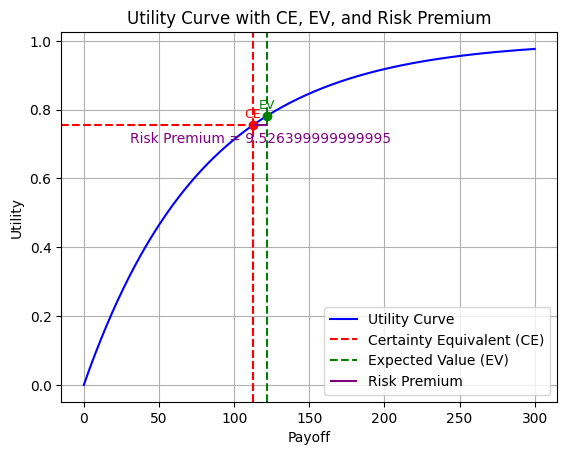

In [ ]:


# Define the range for x
x = np.linspace(0, 300, 400)

# ----------- PARAMETERS -------------
r = 80
x_certainty_eq = 112.5361
x_expected_value = 122.0625
# ------------------------------------

# Calculate the utilities
y_certainty_eq = 1 - math.exp(-x_certainty_eq / r)
y_expected_value = 1 - math.exp(-x_expected_value / r)

# Calculate y using the exponential utility function
y = 1 - np.exp(-x / r)

# Calculate risk premium
risk_premium = x_expected_value - x_certainty_eq

# Plot the utility curve
plt.plot(x, y, label='Utility Curve', color='blue')

# Plot vertical lines for certainty equivalent and expected value
plt.axvline(x=x_certainty_eq, color='red', linestyle='--', label='Certainty Equivalent (CE)')
plt.axvline(x=x_expected_value, color='green', linestyle='--', label='Expected Value (EV)')

# Plot points for certainty equivalent and expected value
plt.plot(x_certainty_eq, y_certainty_eq, 'ro')
plt.plot(x_expected_value, y_expected_value, 'go')

# Add text annotations for CE and EV
plt.text(x_certainty_eq, y_certainty_eq + 0.02, 'CE', fontsize=9, ha='center', color='red')
plt.text(x_expected_value, y_expected_value + 0.02, 'EV', fontsize=9, ha='center', color='green')

# Plot the risk premium as a horizontal line between CE and EV
plt.hlines(y=y_certainty_eq, xmin=x_certainty_eq, xmax=x_expected_value, color='purple', linestyle='-', label='Risk Premium')

# Add text annotation for risk premium
plt.text((x_certainty_eq + x_expected_value) / 2, y_certainty_eq - 0.05, f'Risk Premium = {risk_premium}', fontsize=10, ha='center', color='purple')

# Draw a vertical dashed line corresponding to CE and its utility
plt.axvline(x=x_certainty_eq, ymin=0, ymax=y_certainty_eq, color='red', linestyle='--')
plt.axhline(y=y_certainty_eq, xmin=0, xmax=x_certainty_eq/300, color='red', linestyle='--')

# Set plot labels and title
plt.title('Utility Curve with CE, EV, and Risk Premium')
plt.ylabel('Utility')
plt.xlabel('Payoff')
plt.grid(True)
plt.legend()
plt.show()

# Bayesian network

## Constructing nodes and arcs

In [ ]:
# Constructing nodes
bn=gum.BayesNet('LIDAR System')

id_e=bn.add(gum.LabelizedVariable('e','Electrical Failure ?',['T = 0','F=1']));
id_m=bn.add(gum.LabelizedVariable('m','Mirror Motor Malfunction ?',['T = 0','F=1']));
id_f=bn.add(gum.LabelizedVariable('f','Filter (Optical) damaged ?',['T = 0','F=1']));
id_l=bn.add(gum.LabelizedVariable('l','Lense (Dirty/Damaged) ?',['T = 0','F=1']))
id_ld=bn.add(gum.LabelizedVariable('ld','Lidar Damaged?',['T = 0','F=1']))


bn.addArc(id_e,id_m)
bn.addArc(id_l,id_ld)
bn.addArc(id_f,id_ld)
bn.addArc(id_m,id_ld)
bn

(pyAgrum.BayesNet<double>@0x5c11218eb850) BN{nodes: 5, arcs: 4, domainSize: 32, dim: 13, mem: 208o}

## Prior probablities

In [ ]:
bn.cpt(id_e).fillWith([0.0050,0.9950])
bn.cpt(id_f).fillWith([0.03,0.97])
bn.cpt(id_l).fillWith([0.02,0.98])
bn.cpt(id_m)[:]=[ [1,0],[.03,.97] ]
bn.cpt(id_ld)[:] = [
   [ [[.43,.57], [.31,.69]], [[.41,.59], [.26,.74]] ],
   [ [[.32,.68], [.16,.84]], [[.2,.8], [.10,.90]] ]
]

bn.cpt(id_ld)

(pyAgrum.Potential<double>@0x5c1121b62b80) 
                    ||  ld               |
l     |f     |m     ||T = 0    |F=1      |
------|------|------||---------|---------|
T = 0 |T = 0 |T = 0 || 0.4300  | 0.5700  |
F=1   |T = 0 |T = 0 || 0.3100  | 0.6900  |
T = 0 |F=1   |T = 0 || 0.4100  | 0.5900  |
F=1   |F=1   |T = 0 || 0.2600  | 0.7400  |
T = 0 |T = 0 |F=1   || 0.3200  | 0.6800  |
F=1   |T = 0 |F=1   || 0.1600  | 0.8400  |
T = 0 |F=1   |F=1   || 0.2000  | 0.8000  |
F=1   |F=1   |F=1   || 0.1000  | 0.9000  |

## Inference and prior probabilites


In [ ]:
# Making inference
ie=gum.LazyPropagation(bn)


## Prior probability of Lidar failure

In [ ]:
print (ie.posterior("ld"))
HTML(f"In our BN, $P(W)=${ie.posterior('ld')[:]}")


  ld               |
T = 0    |F=1      |
---------|---------|
 0.1094  | 0.8906  |



## Prior probability of Lidar failure given evidence of electrical failure

In [ ]:
# Making inferences with evidence
ie.setEvidence({'e':0})
ie.makeInference()
print(ie.posterior("ld"))


  ld               |
T = 0    |F=1      |
---------|---------|
 0.2645  | 0.7355  |



## Plotting the DAG

In [ ]:
gum.config['notebook','potential_visible_digits']=2
gnb.sideBySide(bn.cpt("f"),captions=['P(Damaged optical filter ?)'])
gnb.sideBySide(bn.cpt("e"),captions=['P(Electrical Failure ?)'])
gnb.sideBySide(bn.cpt("l"), gnb.getBN(bn,size="3!"),bn.cpt("m")
,captions=['P(Lense (Dirty/Damaged) ?)','','P(Mirror Motor Malfunction ?)'])
gnb.sideBySide(bn.cpt("ld"),captions=['P(Lidar failure ?)'])